# Import manual segmentation results into starfish

Sometimes, automated methods just don't work. We know of at least two formats in use by our users and should write some methods to enable them to use their manual segmented data in starfish: 

* `GeoJSON`
* ImageJ `ROIset`
* ImageJ mask images

ImageJ masks can be created with the [Segmentation Editor](https://imagej.net/Segmentation_Editor) in FIJI. To demonstrate, this example will dump a MERFISH image to disk as a single-plane TIFF that can be loaded into FIJI.

In [3]:
%gui qt5

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io, color, draw
import scipy.ndimage as ndi

import starfish
import starfish.data
from starfish.image import Filter
from starfish.types import Axes, Coordinates, Clip

# set figure DPI for screen viewing
matplotlib.rcParams["figure.dpi"] = 150

/usr/local/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.11.1. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [5]:
merfish = starfish.data.MERFISH()
merfish

<starfish.Experiment (FOVs=496)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
fov_001: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
fov_002: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
fov_003: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
  ...,
}

In [6]:
def load_data(fov: str):
    fov = merfish[fov]
    dapi = fov.get_image("nuclei")
    primary = fov.get_image("primary")
    
    # clip outliers
    clip = Filter.Clip(p_max=99.9, expand_dynamic_range=True)
    clipped_primary = clip.run(primary)
    clipped_dapi = clip.run(dapi)
    
    # max proj then combine the two images
    mp = Filter.MaxProject({Axes.CH, Axes.ROUND, Axes.ZPLANE})
    projected = mp.run(clipped_primary)
    
    # combine images
    combined = np.maximum(primary.xarray.values.squeeze(), projected.xarray.values.squeeze())
    
    return dapi, combined

dapi, combined_image = load_data("fov_000")

100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


Dump the result to TIFF for segmentation.

In [7]:
io.imsave("fov_000.tiff", combined_image)

# Creating masks with Segmentation Manager

The tiff can be dragged and dropped onto FIJI to open.

The SegmentationManager can be reached through `Plugins > Segmentation > Segmentation Editor`

Note: when I segmented this thing, I elected to save it as a tiff image, so we should be able to load that, too. Maybe by delegating to imageio. 

Segmentation workflow: 
- `Plugins > Segmentation > Segmentation Editor`
- Click "polygon selection" (third button from left on GUI)
- Create a polygon, then click the "+" button to finalize it. 
- Repeat until segmented
- Save the resulting mask (I saved as tiff)

## Load the Segmented image back into starfish


Note that when I saved this image, I saved it as an RGB image. This is absolutely unnecessary, and unhelpful, but shows that FIJI has flexibility in how it saves, and that we also may need to either (1) only support label images and make users figure it out, (2) have some flexibility in conversion, or (3) have clear vignettes that demonstrate how to save images in FIJI so they're easily loadable. 

In [8]:
fiji_masks = io.imread("./fov_000.labels.tif")
fiji_masks_gray = skimage.color.rgb2gray(fiji_masks)
mask = fiji_masks_gray.astype(bool)

Convert the mask to a label image, and the label image to a `SegmentationMaskCollection`

In [9]:
# TODO: we really need to allow users to pass coordinates around (that needs to be a top-level item! 
#  If this works already, our type system needs to be clearer about what can be passed. 

label_image = ndi.label(mask)[0]

physical_ticks={
    starfish.types.Coordinates.X: dapi.xarray.coords[starfish.types.Coordinates.X.value],
    starfish.types.Coordinates.Y: dapi.xarray.coords[starfish.types.Coordinates.Y.value]
}
masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
    label_image, physical_ticks=physical_ticks
)

100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


View the mask collection in napari against the dapi image to verify it worked. 

In [10]:
%gui qt5

combined_image.shape
combined_image_stack = np.expand_dims(combined_image, 2)
combined_image_stack = starfish.ImageStack.from_numpy(combined_image_stack)

starfish.display(combined_image_stack, masks=masks)

100%|██████████| 16/16 [00:00<00:00, 54.40it/s]


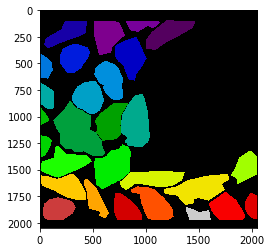

In [11]:
plt.imshow(label_image, cmap=plt.cm.nipy_spectral)

In [13]:
np.save('/Users/dganguli/src/starfish/notebooks/fiji_label_image.npy', label_image)

# Creating polygons with ROI Manager
Might want to work in the [ROImanager](http://imagej.net/docs/guide/146-30.html#fig:The-ROI-Manager) for ROIsets. 

Segmentation workflow: 
- Tools > ROI Manager
- Click "polygon selection" (third button from left on GUI)
- Create a polygon, then click the "+" button to finalize it. 
- Repeat until segmented
- Click "more >>>"
- Click "save" 
- Save the ROISet. 

Here, only segmented a small subset (~4) of the cells for demonstration purposes

In [16]:
import sys
!{sys.executable} -m pip install read_roi

  Running setup.py install for read-roi ... done
You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
from skimage import draw
from read_roi import read_roi_zip

roi_set = read_roi_zip("./RoiSet.zip")

In [23]:
from math import floor, ceil
from typing import Dict, Sequence

import xarray as xr
import pandas as pd

from starfish.core.segmentation_mask import (
    _get_axes_names, SegmentationMaskCollection
)
from starfish.types import Axes

def from_polygons(
    polygons: Sequence[np.ndarray],
    physical_ticks: Dict[Coordinates, Sequence[float]]
) -> SegmentationMaskCollection:
    """
    Creates segmentation masks from a set of polygons.

    Parameters
    ----------
    polygons : List[np.ndrray[int]]
        List of (N, 2) arrays which contain the (y, x) coordinates 
        of the boundaries of the polygons
    physical_ticks : Dict[Coordinates, Sequence[float]]
        Physical coordinates that capture the maximum extent of 
        the polygons. Often the coordinates of the full field of 
        view that encapsulates all polygons.
        
    Notes
    -----
    This method only supports construction of masks from 2D polygons 
    at this time.

    Returns
    -------
    masks : SegmentationMaskCollection
        Masks generated from the polygons.
    """

    dims = Axes.Y.value, Axes.X.value

    masks: List[xr.DataArray] = []

    coords: Dict[str, Union[list, Tuple[str, Sequence]]]

    # for each region (and its properties):
    for label, polygon in enumerate(polygons):
        
        polygon = np.asarray(polygon)
        
        # get the maximum extent of the polygon
        minima = np.floor(np.amin(polygon, axis=0))
        maxima = np.ceil(np.amax(polygon, axis=0))
        bbox = pd.DataFrame({"min": minima, "max": maxima}, index=["y", "x"], dtype=int)
        
        coords = {d: list(range(bbox.loc[d, "min"], bbox.loc[d, "max"]))
                  for d in bbox.index}

        # create physical coordinate labels by taking the overlapping
        # subset from the full span of labels
        for dim, ticks in physical_ticks.items():
            try:
                dim = dim.value
            except AttributeError:  # this is a already a string
                dim = dim
            # magic number alert - this is in 
            # SegmentationMaskCollection.from_label_image too, it's
            # extracting x from xc or y from yc. Unintuitive.
            axis = dim[0]
            pixel_indices = range(bbox.loc[axis, "min"], bbox.loc[axis, "max"])
            coords[dim] = (axis, ticks[pixel_indices])
        
        # name the polygon
        name = str(label + 1)
        name = name.zfill(len(str(len(polygons))))  # pad with zeros
        
        # The polygon will be drawn on a smaller grid, only the physical coordinates
        # should be aware of the full pixel space, we want the origin of the drawn
        # polygon to be (0, 0)
        vertex_row_coords, vertex_col_coords = polygon.T
        vertex_col_coords -= vertex_col_coords.min()
        vertex_row_coords -= vertex_row_coords.min()
        
        # draw a mask from the polygon
        shape = len(coords[Coordinates.Y.value][1]), len(coords[Coordinates.X.value][1])
        mask = np.zeros(shape, dtype=bool)
        fill_row_coords, fill_col_coords = draw.polygon(
            vertex_row_coords, vertex_col_coords, shape
        )
        mask[fill_row_coords, fill_col_coords] = True

        # combine the mask with physical coordinates
        xr_mask = xr.DataArray(
            mask,
            dims=dims,
            coords=coords,
            name=name
        )
        masks.append(xr_mask)
#     import pdb; pdb.set_trace()
    return SegmentationMaskCollection(masks)

In [24]:
def roiset2polygons(roi_set):
    """
    Parameters
    ----------
    roi_set : Dict[str, Any]
        FIJI roi_set containing {'x': Sequence[int], 'y': Sequence[int]}

    Returns
    -------
    List[Array[int]]
        A list of (N, 2) arrays that contain the (y, x) vertices of 
        each polygon
    """
    polygons = []
    for roi in roi_set.values():
        polygon = np.array([roi['y'], roi['x']]).T
        polygons.append(polygon)
    return polygons

In [25]:
polygons = roiset2polygons(roi_set)

This is super cumbersome. 

In [26]:
physical_ticks = {
    "yc" : dapi.xarray.coords["yc"],
    "xc" : dapi.xarray.coords["xc"]
}

But this now works

In [27]:
smc = from_polygons(polygons, physical_ticks=physical_ticks)

In [28]:
starfish.display(dapi, masks=smc)

# GeoJSON to SegmentationMaskCollection

Brian long & Song-Lin Ding segmented their SpaceTx data. It's available here: 

https://spacetx.slack.com/archives/C8ASQLUQ2/p1565297210001200

And a downsampled version of the image that they segmented from, but which does not match the polygons, is here: https://spacetx.slack.com/archives/C8ASQLUQ2/p1566850228008100

In [29]:
import json
with open("SongLinROIS_deduplicated.json", 'rb') as f:
    json_data = json.load(f)

In [30]:
from skimage import io
image = io.imread("mFISH__001_registered-downsampled.png")

/usr/local/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (126067200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


These data are pretty complicated to work with because they're on a different coordinate grid from the image. To save some time, and demonstrate that we can indeed load in these types of polygons, this vignette will negate the values, flipping around the shape cloud.

It calculates the shape on the fly from the boundary of the polygons. 

In [31]:
from math import floor, ceil

def geojson2polygons(geojson: dict):
    polygons = []
    x_max = -np.inf
    y_max = -np.inf
    x_min = np.inf
    y_min = np.inf
    for polygon in geojson["geometries"]:
        arr_pg = -np.asarray(polygon['coordinates']).squeeze()
        polygons.append(arr_pg)
        x_max = max(x_max, max(arr_pg[:, 1]))
        y_max = max(y_max, max(arr_pg[:, 0]))
        x_min = min(x_min, min(arr_pg[:, 1]))
        y_min = min(x_min, min(arr_pg[:, 0]))
    bbox = [floor(y_min), floor(x_min), ceil(y_max), ceil(x_max)]
    return polygons, bbox

allen_polygons, allen_bbox = geojson2polygons(json_data)

In [32]:
allen_bbox

[2165, 2165, 27085, 20826]

In [33]:
physical_ticks = {
    Coordinates.Y: np.arange(allen_bbox[0], allen_bbox[2], dtype=int),
    Coordinates.X: np.arange(allen_bbox[1], allen_bbox[3], dtype=int)
}

Maybe a 1-off error? didn't have time to debug. I guess this is why one writes tests... (-:

In [34]:
allen_smc = from_polygons(allen_polygons, physical_ticks=physical_ticks)

IndexError: index 18661 is out of bounds for axis 0 with size 18661

Anyway, here's a hack

In [35]:
# stolen from skimage, but made more efficient for drawing multiple polygons on the same mask
def polygons2mask(shape, polygons):
    """
    shape is size of image (tuple)
    polygons is list of Nx2 arrays. each array contains vertices for a polygon
    """
    mask = np.zeros(shape, dtype=np.bool)
    for polygon in polygons:
        polygon = np.asarray(polygon)
        vertex_row_coords, vertex_col_coords = polygon.T
        fill_row_coords, fill_col_coords = draw.polygon(
            vertex_row_coords, vertex_col_coords, shape)
        mask[fill_row_coords, fill_col_coords] = True
    return mask

def roiset2mask(shape, roiset):
    """
    constructs a single mask out of a set of fiji rois
    
    shape: size of mask
    roiset: list of fiji rois
    """
    polygons = []
    for roi in roiset.values():
        polygon = np.array([roi['y'], roi['x']]).T
        polygons.append(polygon)
    return polygons2mask(shape, polygons)

def roiset2maskcollection(imagestack, roiset):
    mask = roiset2mask(imagestack.xarray.values.squeeze().shape, roiset)
    label_image = ndi.label(mask)[0]
    physical_ticks={
        starfish.types.Coordinates.X: imagestack.xarray.coords[starfish.types.Coordinates.X.value],
        starfish.types.Coordinates.Y: imagestack.xarray.coords[starfish.types.Coordinates.Y.value]
    }
    masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
        label_image, physical_ticks=physical_ticks
    )
    return masks

def geojson2maskcollection(image: np.ndarray, geojson: dict):
    polygons = []
    x_max = 0
    y_max = 0
    for polygon in geojson["geometries"]:
        arr_pg = -np.asarray(polygon['coordinates']).squeeze()
        polygons.append(arr_pg)
        x_max = max(x_max, max(arr_pg[:, 1]))
        y_max = max(y_max, max(arr_pg[:, 0]))
    mask = polygons2mask((int(y_max), int(x_max)), polygons)
    label_image = ndi.label(mask)[0]

    # if the image were real, we'd do this:
    # # build the image, expand the axes, and transpose the order
    # image = color.rgb2gray(image)
    # image = image[None, None, None, :]
    
    # # fake coordinates are fine, this image is stitched
    # imagestack = starfish.ImageStack.from_numpy(image)
    
    # make a fake image to get coords
    imagestack = starfish.ImageStack.from_numpy(np.zeros((1, 1, 1, int(y_max), int(x_max))))
#     import pdb; pdb.set_trace()
    
    physical_ticks={
        starfish.types.Coordinates.X: imagestack.xarray.coords[starfish.types.Coordinates.X.value],
        starfish.types.Coordinates.Y: imagestack.xarray.coords[starfish.types.Coordinates.Y.value]
    }
    masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
        label_image, physical_ticks=physical_ticks
    )
    return imagestack, masks, label_image

Something in the mask construction is not very fast when operating at scale. We should profile this.

In [36]:
imagestack, masks, label_image = geojson2maskcollection(image, json_data)

/Users/dganguli/src/starfish/starfish/core/imagestack/imagestack.py:349: UserWarning: ImageStack detected as float64. Converting to float32...
  warnings.warn(f"ImageStack detected as {array.dtype}. Converting to float32...")
/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


Napari can't show images bigger than like ~10k x 10k due to GPU memory limitations, apparently, so this will fail. 

This should work, but is a limitation of the way we've programmed starfish.display. 

Just imshow it for now

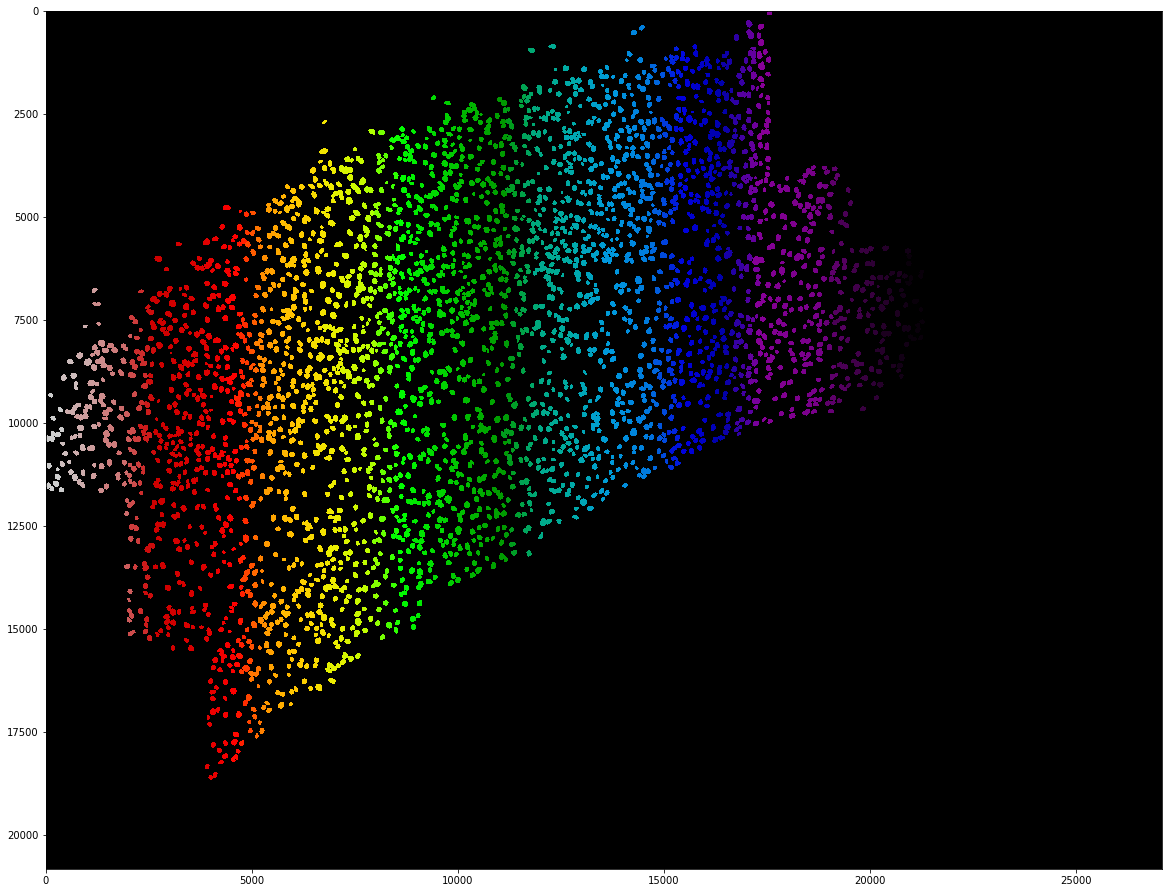

In [69]:
plt.figure(figsize=(20,20))
label_image_transformed = np.fliplr(np.flipud(label_image.T))
plt.imshow(label_image_transformed, cmap=plt.cm.nipy_spectral)
plt.savefig('/Users/dganguli/data/allen_smFISH/seg.png')

In [70]:
print('hior 

hi


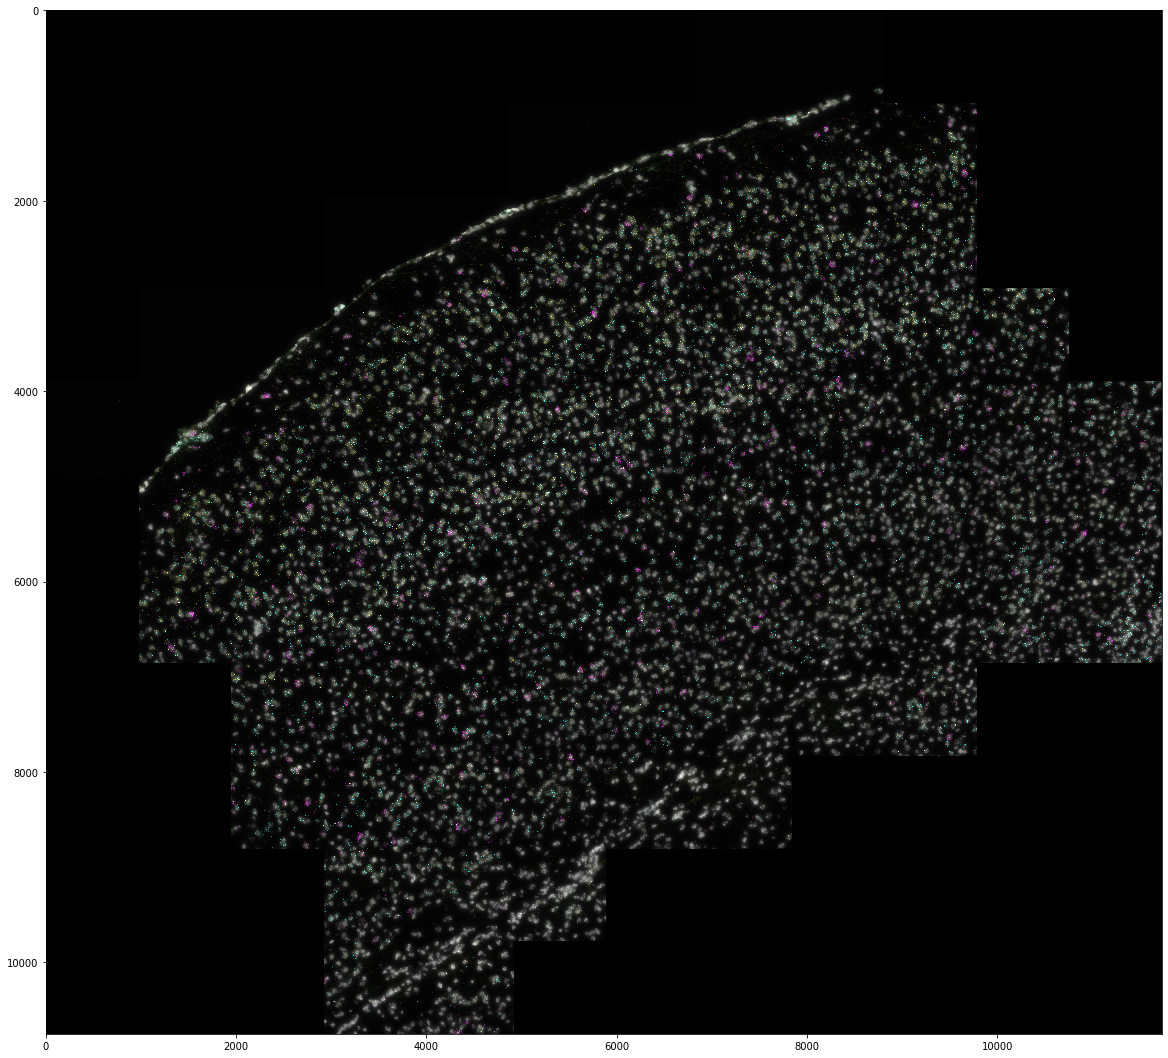

In [41]:
plt.figure(figsize=(20,20))
plt.imshow(image)

In [51]:
image.shape, label_image.shape

((10752, 11725, 3), (27084, 20825))

The `SegmentationMaskCollection` should be fine and should be usable with downstream point assignments, despite napari not working. For downstream point assignments, the coordinate negation should be eliminated from the above function. 

In [63]:
label_image_transformed.shape



(20825, 27084)

In [64]:
np.save?

In [66]:
from skimage.io import imsave

In [68]:
imsave('/Users/dganguli/data/allen_smFISH/seg.png', label_image_transformed)

/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: /Users/dganguli/data/allen_smFISH/seg.png is a low contrast image
  warn('%s is a low contrast image' % fname)


KeyboardInterrupt: 

In [ ]:
fda